# The Validation Set

This notebook explores a subset of the GTSRB (namely the speed signs) to show how the selection of the validation set can affect our expectations when using the net in unseen data.

It covers tensorflow dataset API to load local data:

- how to load local data
- prepare the dataset for training



### References

https://benchmark.ini.rub.de/gtsrb_news.html

https://www.tensorflow.org/tutorials/load_data/images

https://www.tensorflow.org/api_docs/python/tf/data/Dataset

https://www.youtube.com/watch?v=yH1cF7GnoIo    

https://www.datacamp.com/community/tutorials/tensorflow-tutorial    

https://www.wouterbulten.nl/blog/tech/data-augmentation-using-tensorflow-data-dataset/

https://surfertas.github.io/tensorflow/dl/2018/01/24/tf-data-augmentation.html


In [1]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.layers import Conv2D, Input
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,TensorBoard
from tensorflow.keras import backend as K
from tensorflow.keras.layers import LeakyReLU, BatchNormalization

import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
import IPython.display as display

import seaborn as sn
import pandas as pd

BATCH_SIZE = 32
IMAGE_SIZE = 32

2023-04-21 10:35:38.935658: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-21 10:35:39.079161: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-21 10:35:39.082041: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:
2023-04-21 10:35:39.082057: I tensorflow/compiler/xla/stream

### Auxiliary functions for display purposes only

In [2]:
def show_batch(cols, image_batch, label_batch):

    rows = int(BATCH_SIZE / cols) 
    if rows * cols < BATCH_SIZE:
        rows += 1
    width = 3 * rows
    height = 3 * cols
    
    
    f, axes= plt.subplots(rows,cols,figsize=(height,width))
    fig=plt.figure()
    for n in range(BATCH_SIZE):
        
        subplot_title=("class "+ classNames[label_batch[n]==1][0])
        axes.ravel()[n].set_title(subplot_title)  
        axes.ravel()[n].imshow(image_batch[n])
        axes.ravel()[n].axis('off')

    fig.tight_layout()    
    plt.show()
    
    
def show_history(history):
    print(history.history.keys())

    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='lower right')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()    
    
    
def show_accuracies(): 
    fig, ax = plt.subplots()
    X = np.arange(2)

    models = ['bad val set', 'good val set']
    plt.bar(X, [evalV1[1], evalV2[1]], width = 0.4, color = 'b', label='test')
    plt.bar(X + 0.4, [valV1[1], valV2[1]], color = 'r', width = 0.4, label = "val")
    plt.xticks(X + 0.4 / 2, models)
    plt.ylim(top = 1.0, bottom = 0.70)
    plt.legend(loc='upper left')
    plt.show()

    
def show_misclassified(predictions, ground_truth, images, num_rows= 5, num_cols=3):
    
    # Plot the first X test images with wrong predictions.
    num_images = num_rows*num_cols
    plt.figure(figsize=(2*2*num_cols, 2*num_rows))
    i = 0
    k = 0
    while k < len(images) and i < num_images:
        predicted_label = np.argmax(predictions[k])
        gt = np.where(ground_truth[k])[0][0]
        if predicted_label != gt:
            plt.subplot(num_rows, 2*num_cols, 2*i+1)
            plot_image(k, predictions[k], gt, images)
            plt.subplot(num_rows, 2*num_cols, 2*i+2)
            plot_value_array(k, predictions[k], ground_truth)
            i += 1
        k += 1
    plt.tight_layout()
    plt.show()


def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label, img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(classNames[predicted_label],
                                100*np.max(predictions_array),
                                classNames[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(8))
  plt.yticks([])
  thisplot = plt.bar(range(8), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[np.where(true_label)[0][0]].set_color('blue')    

def plot_predictions(predictions, ground_truth, images, num_rows= 5, num_cols=3 ):

    num_images = num_rows*num_cols
    plt.figure(figsize=(2*2*num_cols, 2*num_rows))
    for i in range(min(num_images,len(images))):
        gt = np.where(ground_truth[i])[0][0]
        plt.subplot(num_rows, 2*num_cols, 2*i+1)
        plot_image(i, predictions[i], gt, images)
        plt.subplot(num_rows, 2*num_cols, 2*i+2)
        plot_value_array(i, predictions[i], ground_truth)
    plt.tight_layout()
    plt.show()
    

def show_confusion_matrix(model, dataset):
   
    all_labels = []
    all_preds = []

    for images , labels in dataset.take(-1):  
        numpy_labels = labels.numpy()
        numpy_images = images.numpy()
        preds = model.predict(numpy_images, verbose=0)  
        
        all_labels += [np.argmax(x) for x in numpy_labels]
        all_preds += [np.argmax(x) for x in preds]
        
    conf_mat = tf.math.confusion_matrix(all_labels, all_preds)

    df_cm = pd.DataFrame(conf_mat.numpy(), range(8), range(8))
    plt.figure(figsize=(15,10))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='d') # font size

    plt.show()

    res_correct = {0:0, 1:0, 2:0, 3:0,4:0,5:0,6:0,7:0}
    res_incorrect = {0:0, 1:0, 2:0, 3:0,4:0,5:0,6:0,7:0}
    for i in range(len(all_preds)):
        if all_preds[i] == all_labels[i]:
            res_correct[all_labels[i]] += 1
        else:
            res_incorrect[all_labels[i]] += 1

    for i in range(len(res_correct)):

        print('class: ', i, ' total images: ', res_correct[i] + res_incorrect[i],' % correct: ', res_correct[i] / (res_correct[i] + res_incorrect[i]))

### Auxiliary functions to load images

In [3]:
classNames = np.array(['00000','00001', '00002', '00003', '00004', '00005', '00006', '00007'])

def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == classNames

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_png(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [32,32])

def get_bytes_and_label(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

## Local Settings

set the paths to the image data and where the model and logs will be saved.

In [4]:
data_path = 'gtsrb'
log_and_model_path = 'gtsrb'

In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

listset = tf.data.Dataset.list_files(f'{data_path}/train_full/*/*.png')
datasetV1 = listset.map(get_bytes_and_label, num_parallel_calls=AUTOTUNE)

2023-04-21 10:35:40.841084: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-21 10:35:40.841377: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:
2023-04-21 10:35:40.841448: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:
2023-04-21 10:35:40.841515: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared

In [6]:
for image,label in datasetV1.take(1):
    print('image shape: ', image.numpy().shape)
    print('label: ', label.numpy())
    
dataset_length = datasetV1.cardinality().numpy()
print(dataset_length)

image shape:  (32, 32, 3)
label:  [False False False False  True False False False]
12780


In [7]:
datasetV1 = datasetV1.cache()
datasetV1 = datasetV1.shuffle(buffer_size=dataset_length)
datasetV1 = datasetV1.batch(batch_size=BATCH_SIZE)
datasetV1 = datasetV1.prefetch(buffer_size=AUTOTUNE)

In [8]:
testset = tf.data.Dataset.list_files(f'test/*/*.png')
testset = testset.map(get_bytes_and_label, num_parallel_calls=AUTOTUNE)
testset_length = testset.cardinality().numpy()
print(testset_length)

testset = testset.batch(batch_size=BATCH_SIZE)
testset_length = testset.cardinality().numpy()
print(testset_length)

4170
131


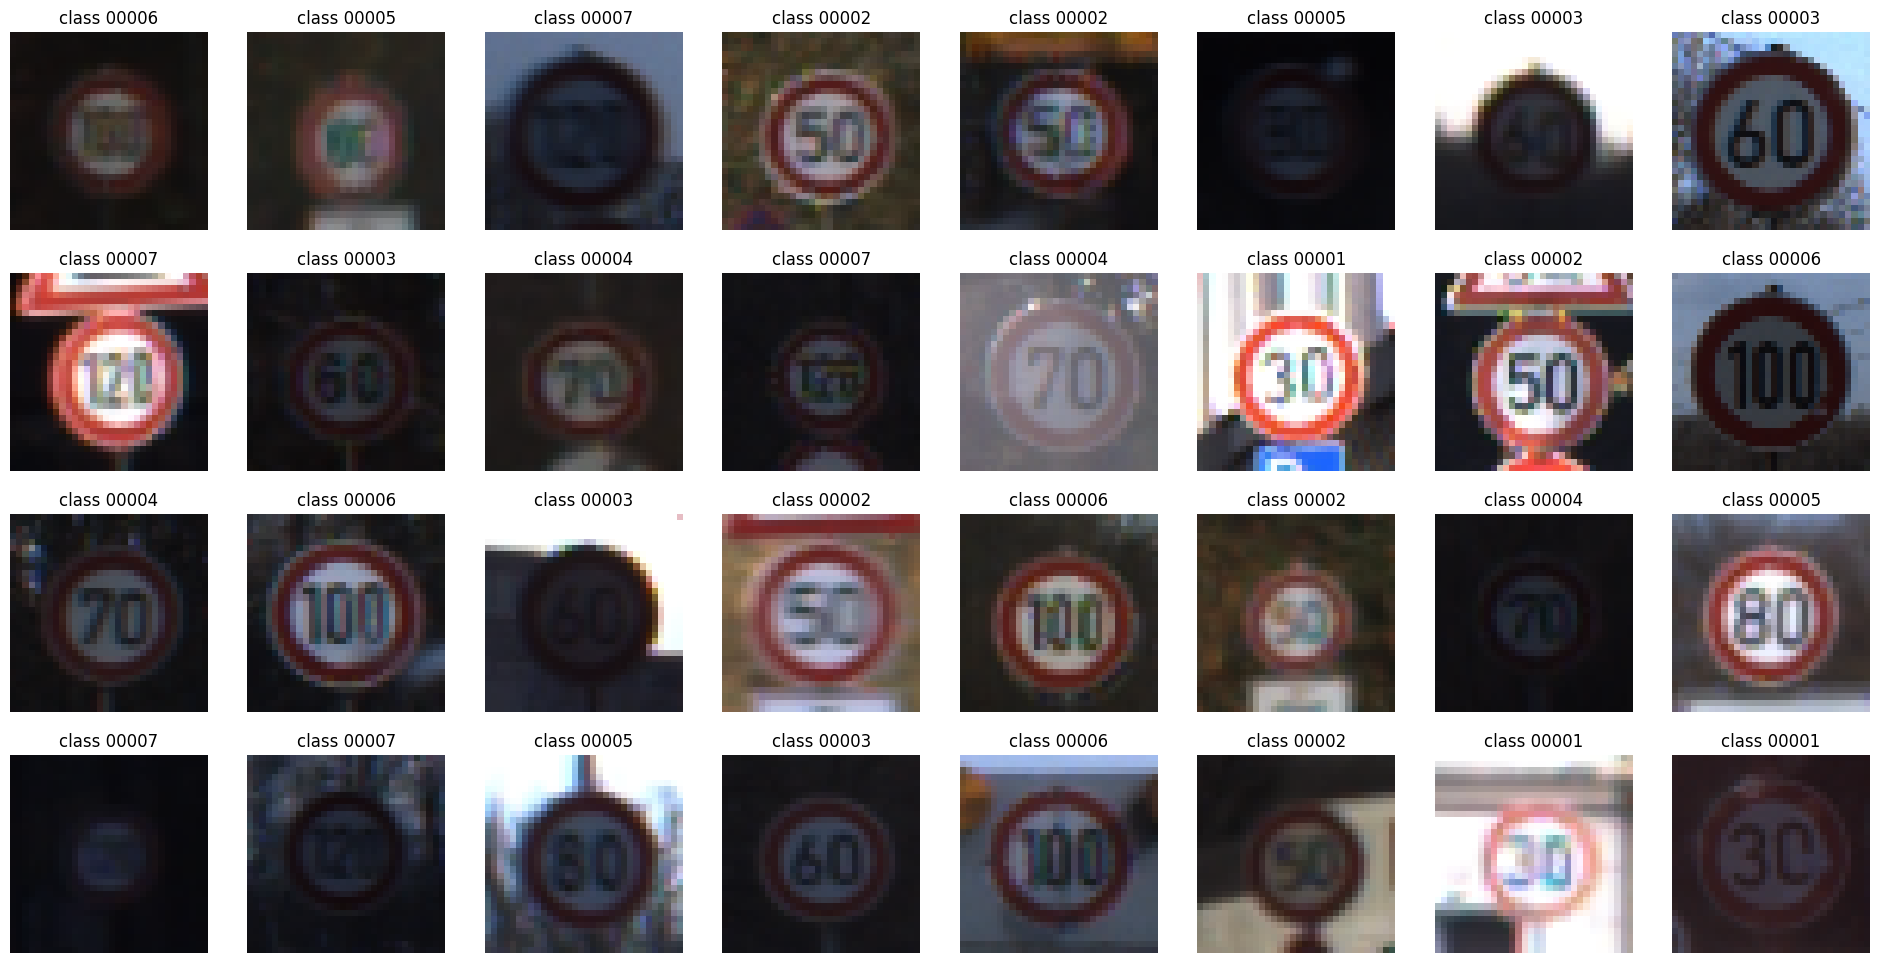

<Figure size 640x480 with 0 Axes>

In [9]:
image_batch,label_batch = next(iter(datasetV1))

show_batch(8,image_batch,label_batch.numpy())

In [10]:
def cnn(classCount, imgSize, channels):
    model = Sequential()
    
    model.add(Input(shape=(imgSize, imgSize, channels)))
    
    model.add(Conv2D(64, (5,5), padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    
    model.add(Conv2D(64, (5,5)))
    model.add(LeakyReLU(alpha=0.01))
    
    model.add(Conv2D(64, (5,5)))
    model.add(LeakyReLU(alpha=0.01))
    
    model.add(Flatten())
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.01))
    
    model.add(Dense(classCount, activation='softmax'))
    
    opt = Adam(learning_rate=0.0001)
    model.compile(optimizer=opt, loss = 'categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [11]:
modelV1 = cnn(8,32,3)
print(modelV1.summary())

tf.keras.utils.plot_model(modelV1, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        4864      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        102464    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 28, 28, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 64)        102464    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 24, 24, 64)        0         
                                                                 
 flatten (Flatten)           (None, 36864)             0

In [12]:
train_size = int(0.8 * dataset_length/BATCH_SIZE)
val_size = int(0.2 * dataset_length/BATCH_SIZE)

print(dataset_length, train_size, val_size)

12780 319 79


In [13]:
train_dataset = datasetV1.take(train_size)
val_dataset = datasetV1.skip(train_size)

In [14]:
def prepareCallbacks(path):
    
    file_path = f'{data_path}/{path}/cp.ckpt'
    
    chechpointer = ModelCheckpoint(filepath=file_path,
                                  monitor='val_accuracy',
                                  verbose=1,
                                  save_weights_only=True,
                                  save_best_only=True)
    
    earlyStopper = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=8, verbose=1)
    
    return file_path, [chechpointer,earlyStopper]

In [15]:
file_pathV1, callbacksV1 = prepareCallbacks('valV1')

history = modelV1.fit(train_dataset, epochs=20, validation_data=val_dataset, callbacks=callbacksV1)

Epoch 1/20
319/319 [==============================] - ETA: 0s - loss: 1.0245 - accuracy: 0.6528
Epoch 1: val_accuracy improved from -inf to 0.89697, saving model to gtsrb/valV1/cp.ckpt
319/319 [==============================] - 38s 118ms/step - loss: 1.0245 - accuracy: 0.6528 - val_loss: 0.3370 - val_accuracy: 0.8970
Epoch 2/20
319/319 [==============================] - ETA: 0s - loss: 0.2581 - accuracy: 0.9264
Epoch 2: val_accuracy improved from 0.89697 to 0.95918, saving model to gtsrb/valV1/cp.ckpt
319/319 [==============================] - 37s 116ms/step - loss: 0.2581 - accuracy: 0.9264 - val_loss: 0.1501 - val_accuracy: 0.9592
Epoch 3/20
319/319 [==============================] - ETA: 0s - loss: 0.1352 - accuracy: 0.9636
Epoch 3: val_accuracy improved from 0.95918 to 0.97201, saving model to gtsrb/valV1/cp.ckpt
319/319 [==============================] - 41s 127ms/step - loss: 0.1352 - accuracy: 0.9636 - val_loss: 0.1083 - val_accuracy: 0.9720
Epoch 4/20
319/319 [=================

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


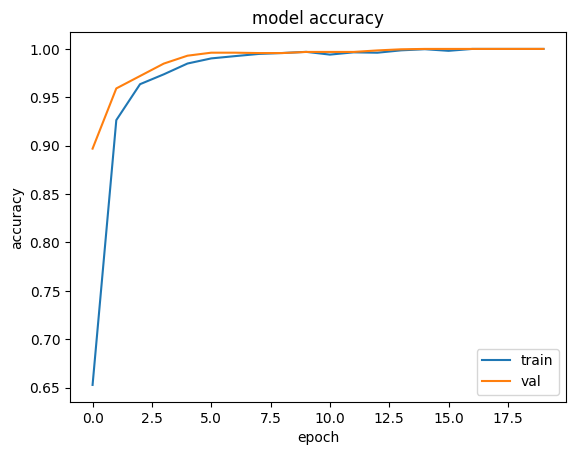

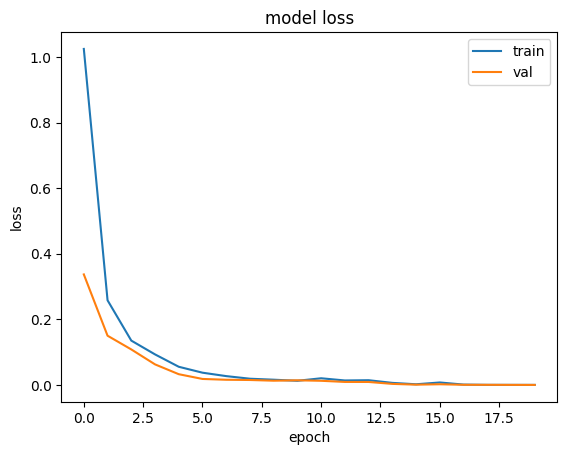

In [16]:
show_history(history)

In [17]:
modelV1.load_weights(file_pathV1)
evalV1 = modelV1.evaluate(testset, verbose=2)
print(evalV1)

valV1 = modelV1.evaluate(val_dataset, verbose=2)

131/131 - 6s - loss: 0.3374 - accuracy: 0.9492 - 6s/epoch - 43ms/step
[0.3373919427394867, 0.9491606950759888]
81/81 - 3s - loss: 6.5214e-04 - accuracy: 1.0000 - 3s/epoch - 41ms/step


In [18]:
listset = tf.data.Dataset.list_files(f'{data_path}/train/*/*.png')
datasetV2 = listset.map(get_bytes_and_label, num_parallel_calls=AUTOTUNE)

datasetV2 = datasetV2.cache()
datasetV2 = datasetV2.shuffle(buffer_size=dataset_length)
datasetV2 = datasetV2.batch(batch_size=BATCH_SIZE)
datasetV2 = datasetV2.prefetch(buffer_size=AUTOTUNE)


listset = tf.data.Dataset.list_files(f'{data_path}/val/*/*.png')
valV2 = listset.map(get_bytes_and_label, num_parallel_calls=AUTOTUNE)

valV2 = valV2.cache()
valV2 = valV2.shuffle(buffer_size=dataset_length)
valV2 = valV2.batch(batch_size=BATCH_SIZE)
valV2 = valV2.prefetch(buffer_size=AUTOTUNE)

In [19]:
modelV2 = cnn(8,32,3)

file_pathV2, callbacksV2 = prepareCallbacks('valV2')
                                            
historyV2 = modelV2.fit(datasetV2, epochs=20, validation_data=valV2, callbacks=callbacksV2)

Epoch 1/20
319/319 [==============================] - ETA: 0s - loss: 0.9835 - accuracy: 0.6575
Epoch 1: val_accuracy improved from -inf to 0.86279, saving model to gtsrb/valV2/cp.ckpt
319/319 [==============================] - 38s 116ms/step - loss: 0.9835 - accuracy: 0.6575 - val_loss: 0.4463 - val_accuracy: 0.8628
Epoch 2/20
319/319 [==============================] - ETA: 0s - loss: 0.2069 - accuracy: 0.9406
Epoch 2: val_accuracy improved from 0.86279 to 0.86318, saving model to gtsrb/valV2/cp.ckpt
319/319 [==============================] - 39s 122ms/step - loss: 0.2069 - accuracy: 0.9406 - val_loss: 0.4044 - val_accuracy: 0.8632
Epoch 3/20
319/319 [==============================] - ETA: 0s - loss: 0.0999 - accuracy: 0.9736
Epoch 3: val_accuracy improved from 0.86318 to 0.88023, saving model to gtsrb/valV2/cp.ckpt
319/319 [==============================] - 41s 129ms/step - loss: 0.0999 - accuracy: 0.9736 - val_loss: 0.3681 - val_accuracy: 0.8802
Epoch 4/20
319/319 [=================

In [20]:
modelV2.load_weights(file_pathV2)
evalV2 = modelV2.evaluate(testset, verbose=2)
val_V2 = modelV2.evaluate(valV2, verbose=2)

131/131 - 5s - loss: 0.3959 - accuracy: 0.9422 - 5s/epoch - 37ms/step
81/81 - 3s - loss: 0.3559 - accuracy: 0.9256 - 3s/epoch - 37ms/step


In [21]:
valV2 = val_V2


In [22]:
import PIL

from PIL import Image

im = Image.open(f'{data_path}/test/00000/s01279.png')

In [23]:
im = im.resize((32,32))
numpy_image = np.asarray(im)
print(numpy_image.shape)

numpy_image = np.expand_dims(numpy_image, axis=0)
print(numpy_image.shape)

(32, 32, 3)
(1, 32, 32, 3)


In [24]:
im_pred = modelV2.predict([numpy_image])
im_pred

1/1 [==============================] - 0s 60ms/step


array([[1., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

1/1 [==============================] - 0s 41ms/step


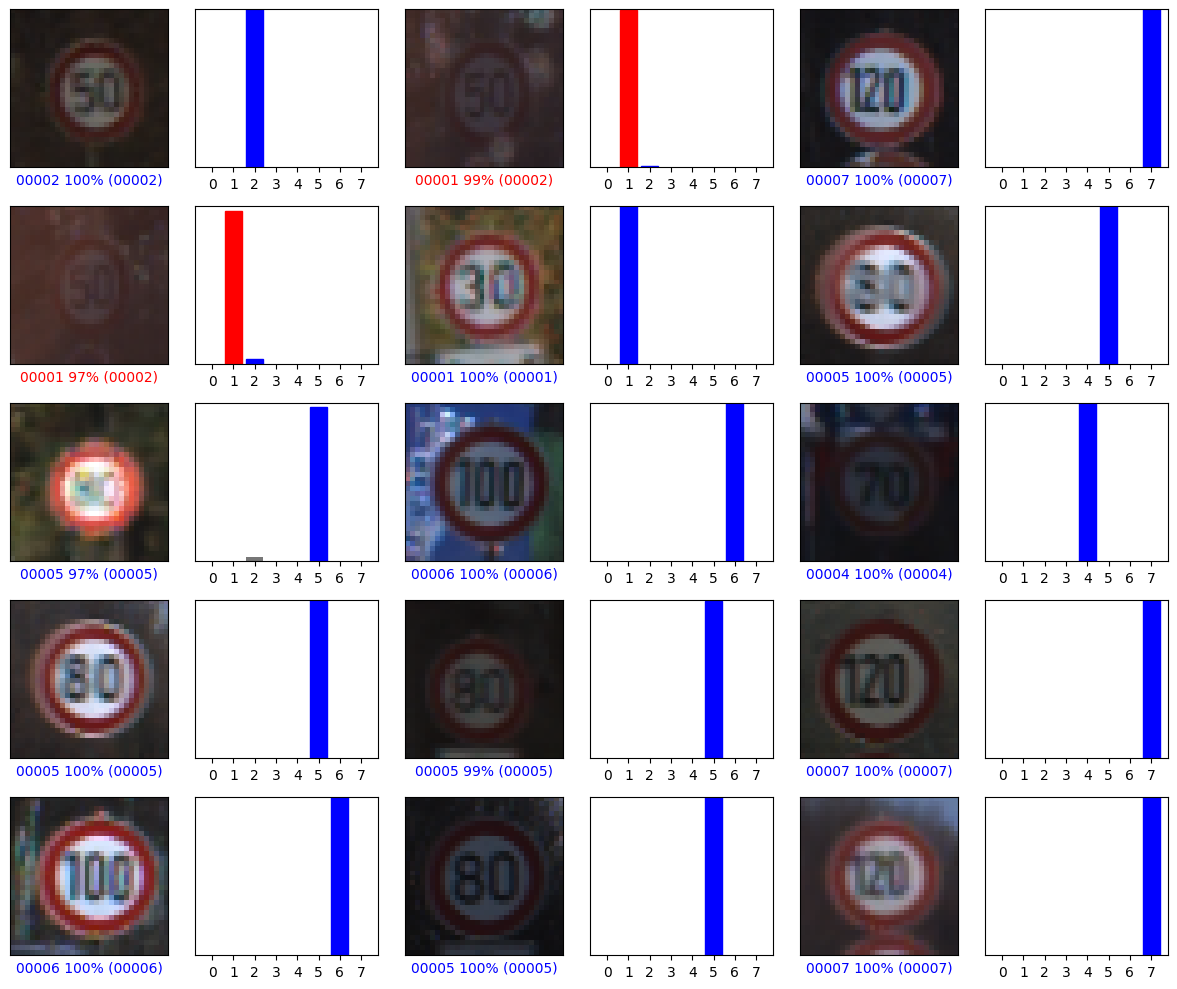

1/1 [==============================] - 0s 44ms/step


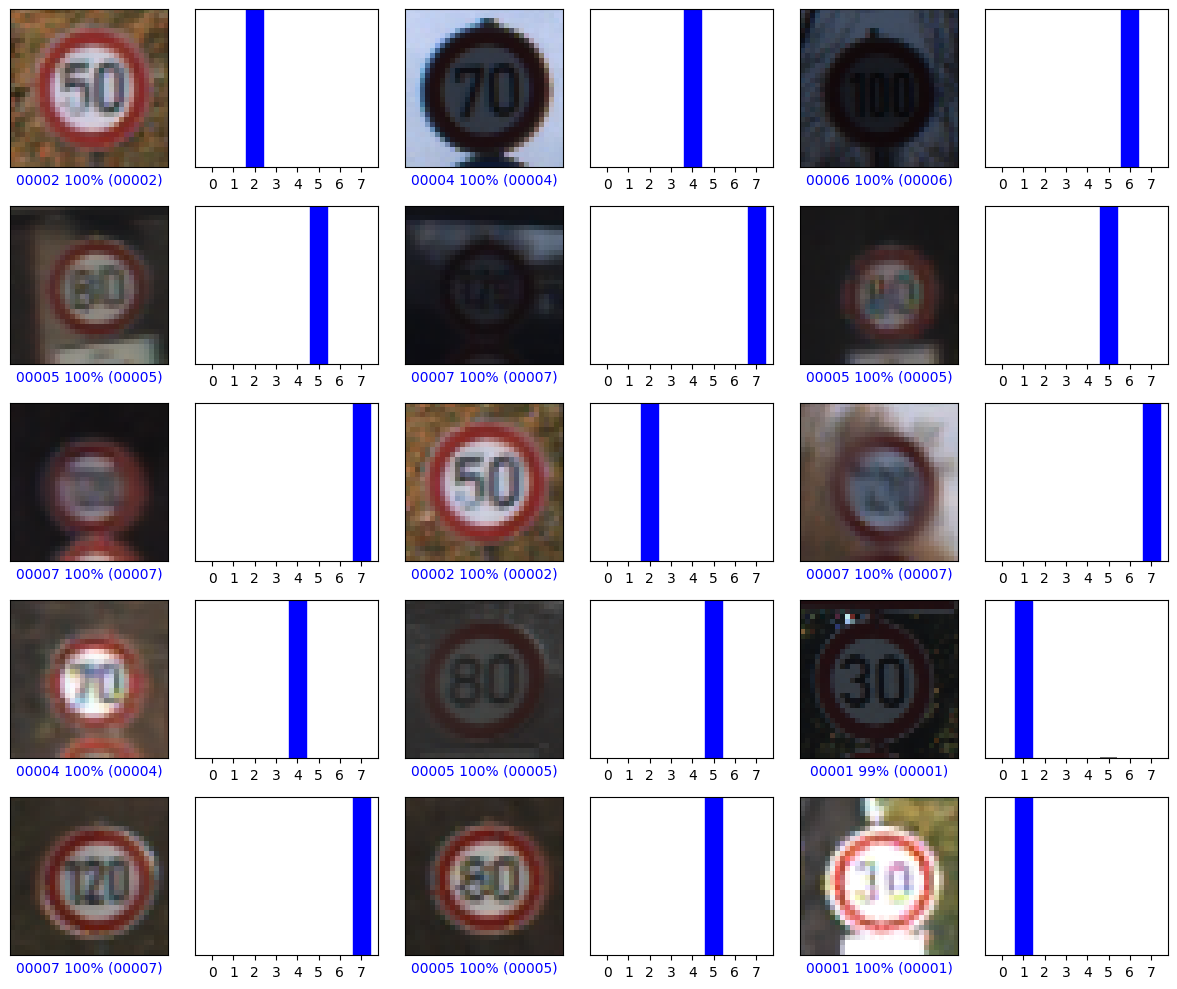

In [26]:
for images, labels in testset.take(2):
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    
    preds = modelV2.predict(numpy_images)
    plot_predictions(preds, numpy_labels, numpy_images, 5,3)

1/1 [==============================] - 0s 49ms/step


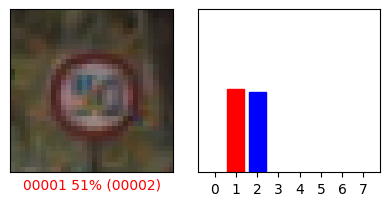

1/1 [==============================] - 0s 51ms/step


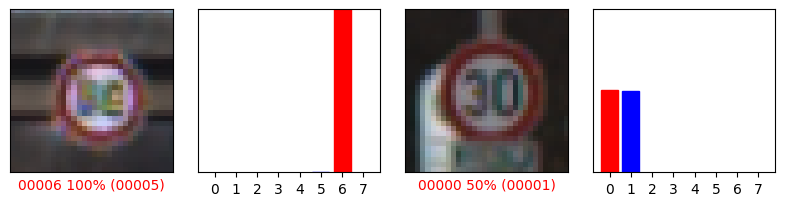

1/1 [==============================] - 0s 53ms/step


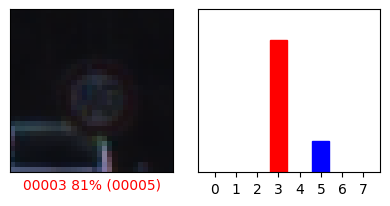

1/1 [==============================] - 0s 50ms/step


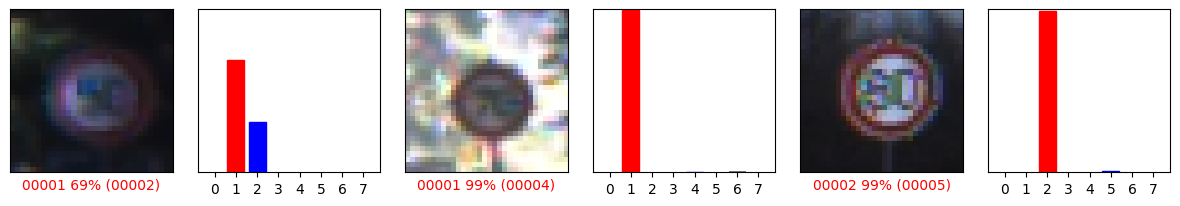

1/1 [==============================] - 0s 50ms/step


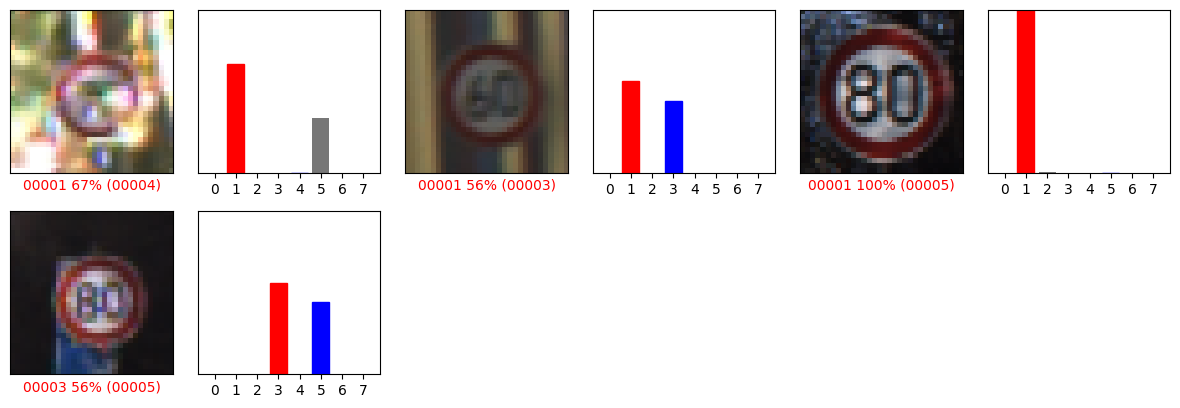

1/1 [==============================] - 0s 50ms/step


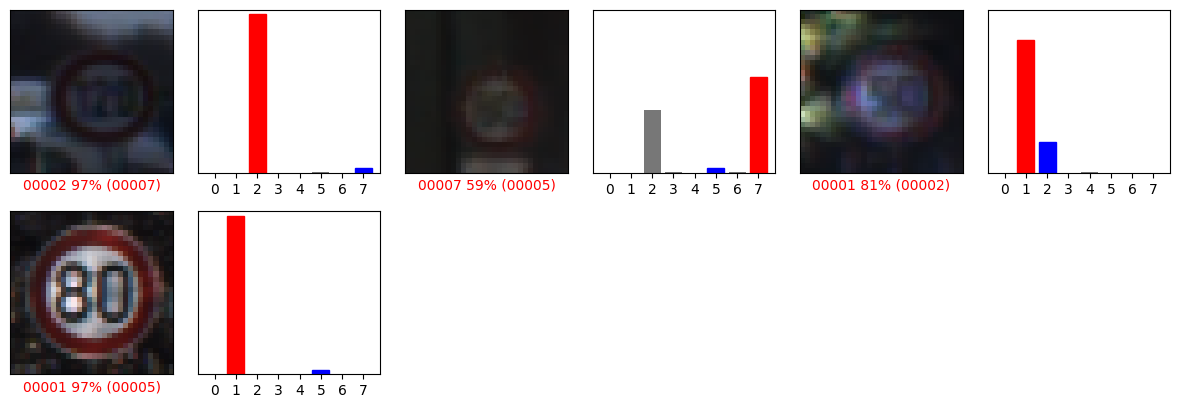

1/1 [==============================] - 0s 51ms/step


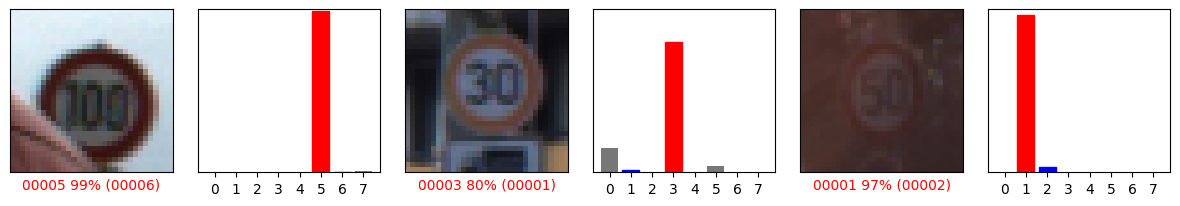

1/1 [==============================] - 0s 52ms/step


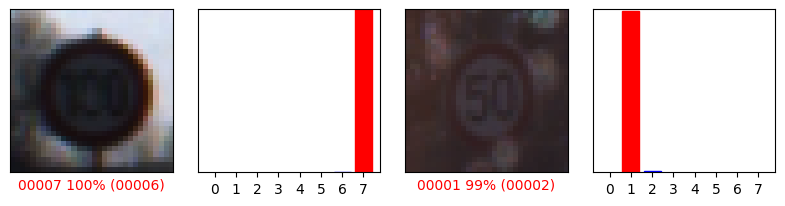

1/1 [==============================] - 0s 51ms/step


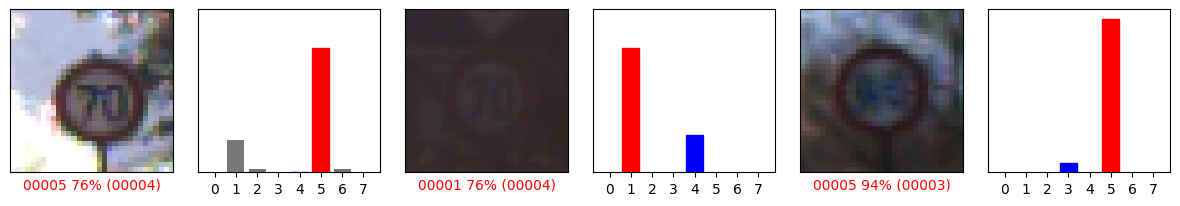

1/1 [==============================] - 0s 50ms/step


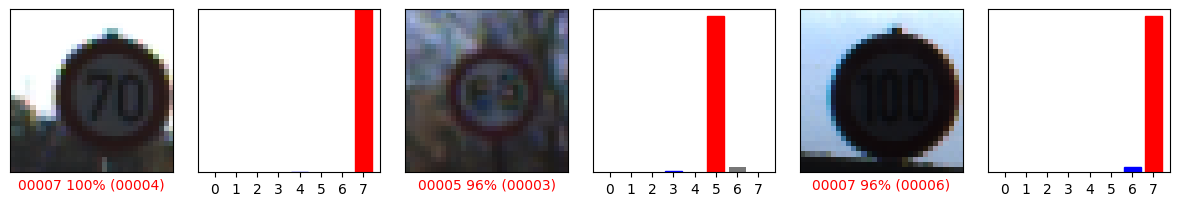

In [27]:
for images, labels in testset.take(10):
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    
    preds = modelV2.predict(numpy_images)
    show_misclassified(preds, numpy_labels, numpy_images,5,3)

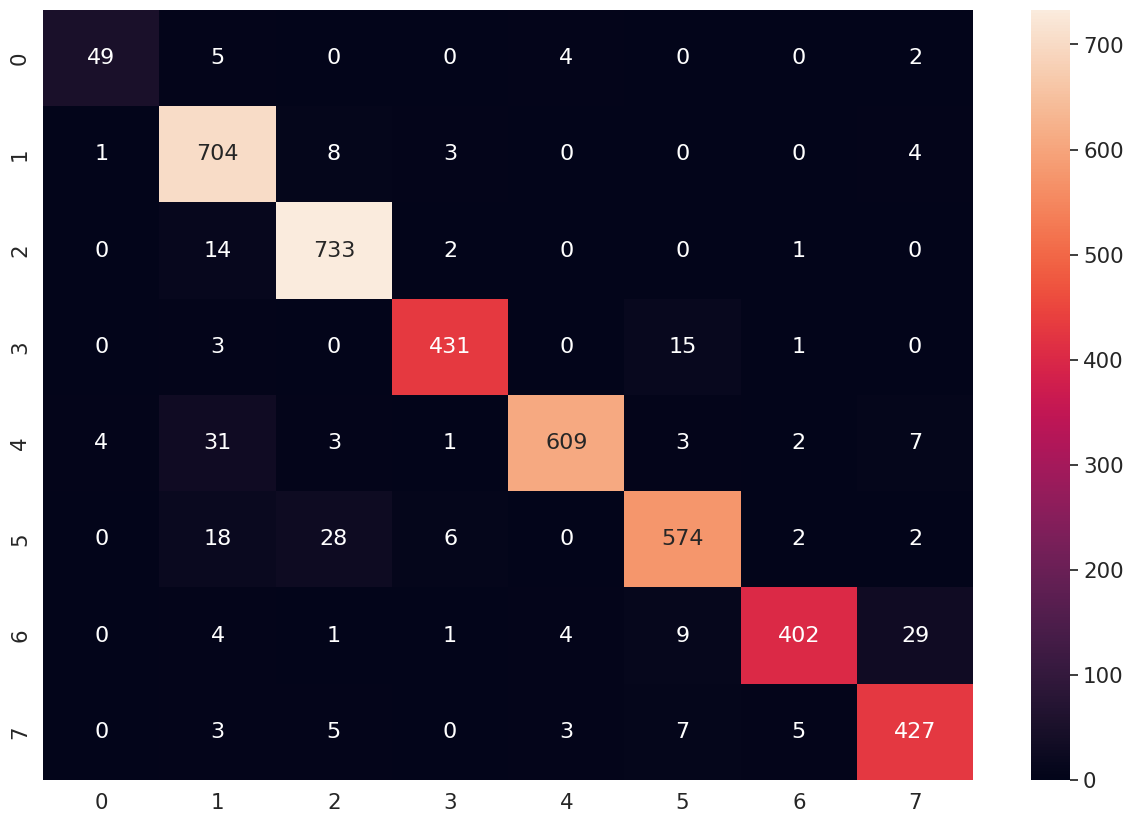

class:  0  total images:  60  % correct:  0.8166666666666667
class:  1  total images:  720  % correct:  0.9777777777777777
class:  2  total images:  750  % correct:  0.9773333333333334
class:  3  total images:  450  % correct:  0.9577777777777777
class:  4  total images:  660  % correct:  0.9227272727272727
class:  5  total images:  630  % correct:  0.9111111111111111
class:  6  total images:  450  % correct:  0.8933333333333333
class:  7  total images:  450  % correct:  0.9488888888888889


In [30]:
show_confusion_matrix(modelV2, testset)